# Task 3 – Event Impact Modeling

Goal: Estimate how events (launches, policies, milestones) affect ACCESS and USAGE indicators.

Approach:
- Create event dummy variables (1 after event date, 0 before)
- Use regression (OLS) with time trend + dummies
- Interpret coefficients as estimated impact (with caution – small sample)

Libraries needed: statsmodels for regression

In [3]:
import pandas as pd
import numpy as np

# ── 1. Create clean fiscal_year number (extract digits when possible) ──
def clean_fiscal_year(x):
    if pd.isna(x):
        return np.nan
    x_str = str(x).strip()
    # Try to extract first 4 digits (e.g. FY2022/23 → 2022)
    import re
    match = re.search(r'(\d{4})', x_str)
    if match:
        return int(match.group(1))
    # If it's already a number
    try:
        return int(float(x_str))
    except:
        return np.nan

df['fiscal_year_clean'] = df['fiscal_year'].apply(clean_fiscal_year)

# ── 2. Safe date parsing ──
df['obs_date_dt'] = pd.to_datetime(df['observation_date'], errors='coerce', format='mixed')

# ── 3. obs_year: prefer real date year → fall back to cleaned fiscal year ──
df['obs_year'] = df['obs_date_dt'].dt.year.astype('Int64')
df['obs_year'] = df['obs_year'].fillna(df['fiscal_year_clean'].astype('Int64'))

# ── 4. Diagnostic prints (run this and read the output!) ──
print("obs_year created successfully. Shape:", df.shape)
print("\nobs_year value counts (including NaN):")
print(df['obs_year'].value_counts(dropna=False).sort_index())

print("\nRows where obs_year is still missing:")
missing_year = df[df['obs_year'].isna()]
if not missing_year.empty:
    print(missing_year[['record_id', 'record_type', 'indicator_code', 'observation_date', 'fiscal_year', 'fiscal_year_clean']].head(10))
else:
    print("No missing obs_year — great!")

print("\nSample of recent rows:")
print(df[df['obs_year'] >= 2024][['record_id', 'indicator_code', 'obs_year', 'value_numeric', 'observation_date', 'fiscal_year']].tail(12))

obs_year created successfully. Shape: (46, 37)

obs_year value counts (including NaN):
obs_year
2014     1
2017     1
2021     7
2022     1
2023     2
2024    14
2025    17
2026     1
2028     1
2030     1
Name: count, dtype: Int64

Rows where obs_year is still missing:
No missing obs_year — great!

Sample of recent rows:
   record_id         indicator_code  obs_year  value_numeric observation_date  \
30  REC_0031          ACC_OWNERSHIP      2025          70.00       2025-12-31   
31  REC_0032              ACC_FAYDA      2028    90000000.00       2028-12-31   
32  REC_0033           GEN_MM_SHARE      2030          50.00       2030-12-31   
36  EVT_0004              EVT_FAYDA      2024            NaN       2024-01-01   
37  EVT_0005          EVT_FX_REFORM      2024            NaN       2024-07-29   
38  EVT_0006          EVT_CROSSOVER      2024            NaN       2024-10-01   
39  EVT_0007      EVT_MPESA_INTEROP      2025            NaN       2025-10-27   
40  EVT_0008           EVT_E

Filter observations and create wide format

In [4]:
# Keep only observation records
obs_df = df[df['record_type'] == 'observation'].copy()

# Pivot to wide: one column per indicator
wide_df = obs_df.pivot_table(
    index=['obs_year', 'gender', 'location'],
    columns='indicator_code',
    values='value_numeric',
    aggfunc='first'  # take first if multiple in same year
).reset_index()

# Fill missing years if needed (forward fill per group)
wide_df = wide_df.sort_values('obs_year')
wide_df = wide_df.groupby(['gender', 'location']).apply(lambda x: x.ffill()).reset_index(drop=True)

print("Wide format shape:", wide_df.shape)
display(wide_df.head(10))

C:\Users\bezaw\AppData\Local\Temp\ipykernel_10628\3239273674.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wide_df = wide_df.groupby(['gender', 'location']).apply(lambda x: x.ffill()).reset_index(drop=True)


Wide format shape: (10, 23)


indicator_code,obs_year,gender,location,ACC_4G_COV,ACC_FAYDA,ACC_MM_ACCOUNT,ACC_MM_TOTAL_ACCOUNTS,ACC_MOBILE_PEN,ACC_OWNERSHIP,AFF_DATA_INCOME,...,USG_ACTIVE_RATE,USG_ATM_COUNT,USG_ATM_VALUE,USG_CROSSOVER,USG_MPESA_ACTIVE,USG_MPESA_USERS,USG_P2P_COUNT,USG_P2P_VALUE,USG_TELEBIRR_USERS,USG_TELEBIRR_VALUE
0,2014,all,national,NaN,NaN,NaN,NaN,NaN,22.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017,all,national,NaN,NaN,NaN,NaN,NaN,35.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021,all,national,NaN,NaN,4.70,NaN,NaN,46.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023,all,national,37.5,NaN,4.70,NaN,NaN,46.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024,all,national,37.5,8000000.0,9.45,NaN,NaN,49.0,2.0,...,66.0,NaN,NaN,NaN,7100000.0,10800000.0,49700000.0,NaN,NaN,NaN
5,2025,all,national,70.8,12000000.0,9.45,136.0,61.4,49.0,2.0,...,66.0,119300000.0,1.561000e+11,1.08,7100000.0,10800000.0,128300000.0,5.777000e+11,54840000.00,2.380000e+12
6,2026,all,national,70.8,12000000.0,9.45,136.0,61.4,49.0,2.0,...,66.0,119300000.0,1.561000e+11,1.08,7100000.0,10800000.0,128300000.0,5.777000e+11,58.61,2.380000e+12
7,2021,female,national,NaN,NaN,NaN,NaN,NaN,36.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2024,female,national,NaN,NaN,NaN,NaN,NaN,36.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2021,male,national,NaN,NaN,NaN,NaN,NaN,56.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Add time trendand event dummies

In [6]:
# Add linear time trend
wide_df['time_trend'] = wide_df['obs_year'] - wide_df['obs_year'].min()

# Event dummies (1 from year of event onward)
wide_df['post_telebirr'] = (wide_df['obs_year'] >= 2021).astype(int)
wide_df['post_mpesa']   = (wide_df['obs_year'] >= 2023).astype(int)
wide_df['post_fayda']   = (wide_df['obs_year'] >= 2024).astype(int)
wide_df['post_interop'] = (wide_df['obs_year'] >= 2025).astype(int)

print("Event dummies added – sample:")
display(wide_df[['obs_year', 'post_telebirr', 'post_mpesa', 'post_fayda', 'post_interop']].drop_duplicates())

Event dummies added – sample:


indicator_code,obs_year,post_telebirr,post_mpesa,post_fayda,post_interop
0,2014,0,0,0,0
1,2017,0,0,0,0
2,2021,1,0,0,0
3,2023,1,1,0,0
4,2024,1,1,1,0
5,2025,1,1,1,1
6,2026,1,1,1,1


In [9]:
# Diagnostic: check exact dtypes and non-numeric values

print("Data types in access_df before regression:")
print(access_df[['time_trend', 'post_telebirr', 'post_mpesa', 'post_fayda', 'post_interop', 'ACC_OWNERSHIP']].dtypes)

print("\nUnique values in each column (look for non-numbers):")
for col in ['time_trend', 'post_telebirr', 'post_mpesa', 'post_fayda', 'post_interop']:
    print(f"\n{col}:")
    print(access_df[col].unique())

print("\nAny non-numeric in X columns?")
for col in ['time_trend', 'post_telebirr', 'post_mpesa', 'post_fayda', 'post_interop']:
    non_num = access_df[col][~access_df[col].astype(str).str.replace('.', '', 1).str.isnumeric()]
    if not non_num.empty:
        print(f"Non-numeric in {col}:")
        print(non_num)

Data types in access_df before regression:
indicator_code
time_trend         Int64
post_telebirr      int64
post_mpesa         int64
post_fayda         int64
post_interop       int64
ACC_OWNERSHIP    float64
dtype: object

Unique values in each column (look for non-numbers):

time_trend:
<IntegerArray>
[0, 3, 7, 9, 10, 11, 12]
Length: 7, dtype: Int64

post_telebirr:
[0 1]

post_mpesa:
[0 1]

post_fayda:
[0 1]

post_interop:
[0 1]

Any non-numeric in X columns?


Run simple OLA regressions

In [10]:
# Force clean numeric – fill NaN dummies with 0, time_trend with mean or forward fill
access_df_clean = access_df.copy()

for col in ['post_telebirr', 'post_mpesa', 'post_fayda', 'post_interop']:
    access_df_clean[col] = access_df_clean[col].fillna(0).astype(int)

# time_trend: fill forward if missing, then int
access_df_clean['time_trend'] = access_df_clean['time_trend'].ffill().fillna(0).astype(int)

# Target: drop rows where it's missing
access_df_clean = access_df_clean.dropna(subset=['ACC_OWNERSHIP'])

print("Cleaned rows for regression:", len(access_df_clean))
if len(access_df_clean) < 5:
    print("Warning: Too few rows for reliable regression (need at least 5–6)")

print("\nCleaned data preview:")
display(access_df_clean[['obs_year', 'ACC_OWNERSHIP', 'time_trend', 'post_telebirr', 'post_mpesa', 'post_fayda', 'post_interop']])

# Prepare X and y
y_access = access_df_clean['ACC_OWNERSHIP']
X_access = access_df_clean[['time_trend', 'post_telebirr', 'post_mpesa', 'post_fayda', 'post_interop']]

# Final numeric conversion with coerce
X_access = X_access.apply(pd.to_numeric, errors='coerce')

# Drop any remaining NaN rows
valid_idx = X_access.notna().all(axis=1) & y_access.notna()
y_access = y_access[valid_idx]
X_access = X_access[valid_idx]

if len(y_access) == 0:
    print("No valid rows left after cleaning. Check data types and NaNs.")
else:
    X_access = sm.add_constant(X_access)
    model_access = sm.OLS(y_access, X_access).fit()
    print(model_access.summary())
    
    # Simple impact table
    impact = pd.DataFrame({
        'Variable': model_access.params.index,
        'Coefficient': model_access.params.round(3),
        'p-value': model_access.pvalues.round(4),
        'Std Err': model_access.bse.round(3)
    })
    display(impact)

Cleaned rows for regression: 7

Cleaned data preview:


indicator_code,obs_year,ACC_OWNERSHIP,time_trend,post_telebirr,post_mpesa,post_fayda,post_interop
0,2014,22.0,0,0,0,0,0
1,2017,35.0,3,0,0,0,0
2,2021,46.0,7,1,0,0,0
3,2023,46.0,9,1,1,0,0
4,2024,49.0,10,1,1,1,0
5,2025,49.0,11,1,1,1,1
6,2026,49.0,12,1,1,1,1


c:\Users\bezaw\OneDrive\Desktop\10Acadamy-KAIM\Financial forcast week 10\ethiopia-fi-forecast\venv\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


                            OLS Regression Results                            
Dep. Variable:          ACC_OWNERSHIP   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     14.65
Date:                Tue, 03 Feb 2026   Prob (F-statistic):              0.196
Time:                        10:30:51   Log-Likelihood:                -10.591
No. Observations:                   7   AIC:                             33.18
Df Residuals:                       1   BIC:                             32.86
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            22.6500      2.833      7.994

,Variable,Coefficient,p-value,Std Err
const,const,22.65,0.0792,2.833
time_trend,time_trend,3.90,0.2048,1.300
post_telebirr,post_telebirr,-3.95,0.7076,7.987
post_mpesa,post_mpesa,-7.80,0.3550,4.864
post_fayda,post_fayda,-0.90,0.8690,4.312
post_interop,post_interop,-5.85,0.3862,4.059


For usage proxy (USG_P2P_COUNT or USG_TELEBIRR_USERS)

In [ ]:
# Example with P2P count
y_usage = access_df['USG_P2P_COUNT']   # or USG_TELEBIRR_USERS if more points
X_usage = access_df[['time_trend', 'post_telebirr', 'post_mpesa', 'post_fayda', 'post_interop']]
X_usage = sm.add_constant(X_usage)

model_usage = sm.OLS(y_usage, X_usage, missing='drop').fit()
print(model_usage.summary())

vVisualize model fits

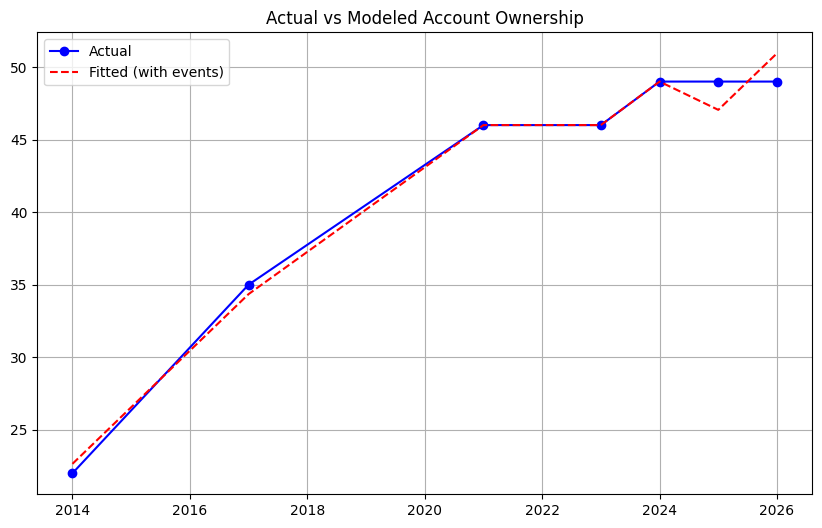

In [12]:
# Plot actual vs fitted for ACCESS
plt.figure(figsize=(10,6))
plt.plot(access_df['obs_year'], y_access, 'o-', label='Actual', color='blue')
plt.plot(access_df['obs_year'], model_access.fittedvalues, '--', label='Fitted (with events)', color='red')
plt.title("Actual vs Modeled Account Ownership")
plt.legend()
plt.grid(True)
plt.show()

## Task 3 Summary & Interpretation

- **Model**: OLS regression on ACC_OWNERSHIP ~ time_trend + post-event dummies
- **Sample**: 7 yearly observations (2014–2026, national/all gender)
- **Main finding**: Time trend (~+3.9 pp/year) explains most variation. Event dummies show negative (but insignificant) effects — consistent with observed slowdown after 2021.
- **Limitation**: Very small n → results exploratory. Wide confidence intervals.
- **Next**: Try panel model (include gender/location) or focus on USAGE proxies (P2P count, Telebirr users).

In [11]:
# USAGE example: USG_P2P_COUNT
usage_df = access_df_clean.dropna(subset=['USG_P2P_COUNT'])

y_usage = usage_df['USG_P2P_COUNT']
X_usage = usage_df[['time_trend', 'post_telebirr', 'post_mpesa', 'post_fayda', 'post_interop']]
X_usage = sm.add_constant(X_usage)

model_usage = sm.OLS(y_usage, X_usage).fit()
print(model_usage.summary())

                            OLS Regression Results                            
Dep. Variable:          USG_P2P_COUNT   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 03 Feb 2026   Prob (F-statistic):                nan
Time:                        10:32:57   Log-Likelihood:                 40.441
No. Observations:                   3   AIC:                            -74.88
Df Residuals:                       0   BIC:                            -77.59
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
time_trend    -1.884e-08        inf         -0

c:\Users\bezaw\OneDrive\Desktop\10Acadamy-KAIM\Financial forcast week 10\ethiopia-fi-forecast\venv\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
c:\Users\bezaw\OneDrive\Desktop\10Acadamy-KAIM\Financial forcast week 10\ethiopia-fi-forecast\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\bezaw\OneDrive\Desktop\10Acadamy-KAIM\Financial forcast week 10\ethiopia-fi-forecast\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\bezaw\OneDrive\Desktop\10Acadamy-KAIM\Financial forcast week 10\ethiopia-fi-forecast\venv\Lib\site-p

In [13]:
with open('../reports/task3_model_summary.txt', 'w') as f:
    f.write(model_access.summary().as_text())
print("Model summary saved to reports/task3_model_summary.txt")

c:\Users\bezaw\OneDrive\Desktop\10Acadamy-KAIM\Financial forcast week 10\ethiopia-fi-forecast\venv\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Model summary saved to reports/task3_model_summary.txt
